# Data Science - Mind the Gap!

In this notebook the Seatle airbnb database will be analyzed by the __CRISP-DM__ steps.

## Import Modules
The first step is loading all required modules, which will be used during this process.

In [1]:
import numpy as np
import pandas as pd

First of all, let's have a look on the shape of the dataframes.

In [2]:
# read all elements of csv files
listings = pd.read_csv('./listings.csv')
calendar = pd.read_csv('./calendar.csv')
reviews  = pd.read_csv('./reviews.csv' )

In [3]:
# print the shape of the csv files
print('Shape of listings: ', listings.shape[0], 'x', listings.shape[1])
print('Shape of calendar: ', calendar.shape[0], 'x', calendar.shape[1])
print('Shape of reviews : ',  reviews.shape[0], 'x',  reviews.shape[1])

Shape of listings:  3818 x 92
Shape of calendar:  1393570 x 4
Shape of reviews :  84849 x 6


Starting with the dataframe of the calendar, it's helpful to see what values are in the database.

In [4]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


Since there are some NaN values and a column we want to get rid of, we start with that.

In [5]:
# drop column, which is not required
dataframe = calendar.drop(['available'], axis='columns')

dataframe.head()

,listing_id,date,price
0,241032,2016-01-04,$85.00
1,241032,2016-01-05,$85.00
2,241032,2016-01-06,NaN
3,241032,2016-01-07,NaN
4,241032,2016-01-08,NaN


As a next step the data types of each column will be analyzed.

In [6]:
dataframe.dtypes

listing_id     int64
date          object
price         object
dtype: object

### Extracting Data

As seen above the price column contains '$' and is treated as objects. 

In [7]:
# drop all na-values of price
dataframe = dataframe.dropna(axis='index', subset=['price'])

dataframe.head()

,listing_id,date,price
0,241032,2016-01-04,$85.00
1,241032,2016-01-05,$85.00
9,241032,2016-01-13,$85.00
10,241032,2016-01-14,$85.00
14,241032,2016-01-18,$85.00


Therefore, each item will be transformed to float values.

In [8]:
# convert each item by removing unwanted strings
dataframe['price'] = dataframe['price'].apply(lambda item: float(item.replace('$','').replace(',','')))

dataframe.head()

,listing_id,date,price
0,241032,2016-01-04,85.0
1,241032,2016-01-05,85.0
9,241032,2016-01-13,85.0
10,241032,2016-01-14,85.0
14,241032,2016-01-18,85.0


For the rest we will focus on all review of the year 2016.

In [9]:
filtering = lambda item: '2016' in item['date']

# apply time filter to dataframe
dataframe = dataframe[dataframe.apply(filtering, axis='columns')]

# convert each item to date-time
dataframe['date'] = pd.to_datetime(dataframe['date'])

dataframe.head()

,listing_id,date,price
0,241032,2016-01-04,85.0
1,241032,2016-01-05,85.0
9,241032,2016-01-13,85.0
10,241032,2016-01-14,85.0
14,241032,2016-01-18,85.0


With this step we receive a clean dataset with correct data types inside.

In [10]:
dataframe.dtypes

listing_id             int64
date          datetime64[ns]
price                float64
dtype: object

## When to travel?

In this section we want to analyze when to travel. Therefore, we start by calculating the mean price for each listing in order to predict the best time period in which we save the most money.

In [11]:
# average price for each listing
average = dataframe.groupby(['listing_id']).mean()

average.head()

,price
listing_id,
3335,120.000000
4291,82.000000
5682,53.964286
6606,92.865014
7369,85.000000


Add new column to dataframe with average of each listing

In [12]:
# search for average price of each listing and add as new column
dataframe['average'] = dataframe['listing_id'].apply(lambda item: average['price'][item])

dataframe.head()

,listing_id,date,price,average
0,241032,2016-01-04,85.0,85.0
1,241032,2016-01-05,85.0,85.0
9,241032,2016-01-13,85.0,85.0
10,241032,2016-01-14,85.0,85.0
14,241032,2016-01-18,85.0,85.0


As a next step there will be a new column containing the difference between each listing's average and the current price for this timepoint.

In [13]:
dataframe['delta'] = dataframe['price'] - dataframe['average']

dataframe.head()

,listing_id,date,price,average,delta
0,241032,2016-01-04,85.0,85.0,0.0
1,241032,2016-01-05,85.0,85.0,0.0
9,241032,2016-01-13,85.0,85.0,0.0
10,241032,2016-01-14,85.0,85.0,0.0
14,241032,2016-01-18,85.0,85.0,0.0


### Grouping Data

Since we have all differences in price calculated over the total year, we would like to group this information by month.

In [14]:
monthly = dataframe

# sort by date index
monthly.index = monthly['date']

# remove this column
monthly = monthly.drop(['listing_id'], axis='columns')

# grouping by month
monthly = monthly.groupby(pd.Grouper(freq='M')).mean()

monthly.head()

,price,average,delta
date,,,
2016-01-31,121.568409,135.768265,-14.199855
2016-02-29,124.293927,135.013267,-10.719340
2016-03-31,128.644488,134.587649,-5.943161
2016-04-30,135.097005,138.086074,-2.989069
2016-05-31,139.538183,138.179081,1.359101


### Visualization

In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure();

# set list of strings for x axis
monthly.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"];

# define colors by this colormap
viridis = cm.get_cmap('viridis', 12)

# use bars to plot the delta val
monthly['delta'].plot.bar(color=viridis.colors, title='Price compared to average');

plt.axhline(0, color='red');

# saving the result as png file
plt.savefig('when_to_travel.png')

## Where to travel

In this section we want to analyze where to travel. First of all we receive all relevant columns.

In [16]:
# receive subset of the total dataframe
dataframe = listings[['zipcode', 'latitude', 'longitude', 'review_scores_rating', 'price', 'beds']]

dataframe.head()

,zipcode,latitude,longitude,review_scores_rating,price,beds
0,98119,47.636289,-122.371025,95.0,$85.00,1.0
1,98119,47.639123,-122.365666,96.0,$150.00,1.0
2,98119,47.629724,-122.369483,97.0,$975.00,7.0
3,98119,47.638473,-122.369279,NaN,$100.00,2.0
4,98119,47.632918,-122.372471,92.0,$450.00,3.0


After that we want to drop all NaN values inside the dataframe.

In [17]:
# droping all na-values 
dataframe = dataframe.dropna()

dataframe.head()

,zipcode,latitude,longitude,review_scores_rating,price,beds
0,98119,47.636289,-122.371025,95.0,$85.00,1.0
1,98119,47.639123,-122.365666,96.0,$150.00,1.0
2,98119,47.629724,-122.369483,97.0,$975.00,7.0
4,98119,47.632918,-122.372471,92.0,$450.00,3.0
5,98119,47.630525,-122.366174,95.0,$120.00,1.0


### Transform Data
As seen in the previous section, the price columns needs to be transformed into float values and divided by the number of beds.

In [18]:
# converts values to float
dataframe['price'] = dataframe['price'].apply(lambda item: float(item.replace('$','').replace(',',''))) 

# divide by number of beds
dataframe['price'] = dataframe['price'] / dataframe['beds']

dataframe.head()

,zipcode,latitude,longitude,review_scores_rating,price,beds
0,98119,47.636289,-122.371025,95.0,85.000000,1.0
1,98119,47.639123,-122.365666,96.0,150.000000,1.0
2,98119,47.629724,-122.369483,97.0,139.285714,7.0
4,98119,47.632918,-122.372471,92.0,150.000000,3.0
5,98119,47.630525,-122.366174,95.0,120.000000,1.0


So let's have a look on the shape and types of the data frame.

In [19]:
dataframe.shape

(3165, 6)

In [20]:
dataframe.dtypes

zipcode                  object
latitude                float64
longitude               float64
review_scores_rating    float64
price                   float64
beds                    float64
dtype: object

### Transform Data
In the next step all invalid zipcodes will be filtered.

In [21]:
# apply filter for valid zipcodes
dataframe = dataframe[dataframe['zipcode'].str.len() == 5]

dataframe.head()

,zipcode,latitude,longitude,review_scores_rating,price,beds
0,98119,47.636289,-122.371025,95.0,85.000000,1.0
1,98119,47.639123,-122.365666,96.0,150.000000,1.0
2,98119,47.629724,-122.369483,97.0,139.285714,7.0
4,98119,47.632918,-122.372471,92.0,150.000000,3.0
5,98119,47.630525,-122.366174,95.0,120.000000,1.0


After this it's possible to convert the values to integers.

In [22]:
# convert each item to int
dataframe['zipcode'] = dataframe['zipcode'].apply(lambda item: int(item))

In [23]:
# renaming to region
region = dataframe

### Distance Metric
In the next step we want to measure the distance from the listing to the center of the city.

In [24]:
# mean center values
center_latitude  = region['latitude' ].mean()
center_longitude = region['longitude'].mean()

Calculate the distance to center for each listing in dataframe.

In [25]:
def distance(x, y):    
    """
    Calcuate distance according to center of city
    """
    x = x - center_latitude
    y = y - center_longitude
    
    # euclidean norm
    return np.sqrt(x*x + y*y)

# calculate distance to center
region['distance'] = distance(region['latitude'], region['longitude'])

region.head()

,zipcode,latitude,longitude,review_scores_rating,price,beds,distance
0,98119,47.636289,-122.371025,95.0,85.000000,1.0,0.038922
1,98119,47.639123,-122.365666,96.0,150.000000,1.0,0.034436
2,98119,47.629724,-122.369483,97.0,139.285714,7.0,0.036643
4,98119,47.632918,-122.372471,92.0,150.000000,3.0,0.039842
5,98119,47.630525,-122.366174,95.0,120.000000,1.0,0.033370


### Scaling 
Let's have a look on how much the values differ in total to the distance.

In [26]:
region['distance'].max()

0.1446485345511527

In [27]:
region['distance'].min()

0.0043099729644810354

### Scoring
In this section we have to define a score in order to rank all listings. Therefore, we begin by the term 'review/price' which will indicates the best ratings for a given price.

In [28]:
# score defined by 'rating/price'
region['score'] = region['review_scores_rating'] / region['price']

But this term will be punished by the distance to the center of the city. Since central places save time of traveling the score will be subtracted by the distance to the center.

In [29]:
# evaluation for scaling terms
max_score    = region['score'].max()
max_distance = region['distance'].max()

# adapt score by distance terms
region['score'] = region['score'] - max_score * (region['distance'] / max_distance)

So let's have a look on the new dataframe entries.

In [30]:
region.head()

,zipcode,latitude,longitude,review_scores_rating,price,beds,distance,score
0,98119,47.636289,-122.371025,95.0,85.000000,1.0,0.038922,-4.150716
1,98119,47.639123,-122.365666,96.0,150.000000,1.0,0.034436,-4.021036
2,98119,47.629724,-122.369483,97.0,139.285714,7.0,0.036643,-4.263378
4,98119,47.632918,-122.372471,92.0,150.000000,3.0,0.039842,-4.779510
5,98119,47.630525,-122.366174,95.0,120.000000,1.0,0.033370,-3.725148


## Visualization

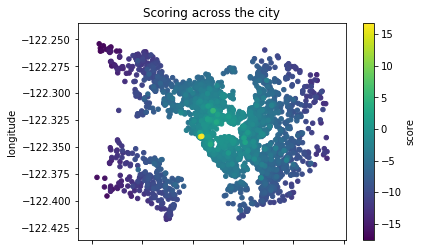

In [36]:
plt.figure();

# sorting all values by scores
region = region.sort_values(by=['score'])
    
# create scatter plot for score    
region.plot.scatter(x='latitude', y='longitude', c='score', colormap='viridis', title='Scoring across the city');           

# saving the result as png file
plt.savefig('where_to_stay.png')

## Zipcodes

Which zipcode has the highest average of this score?

In [32]:
# group by zipcodes and sort values
scoring = region.groupby('zipcode').mean()['score'].sort_values(ascending=False)

scoring.head()

zipcode
98102   -0.640078
98101   -1.044300
98109   -1.363843
98121   -1.390210
98104   -2.347079
Name: score, dtype: float64

# What to spent?

In this section we want to visualize the heatmap between price and reviews, in order to answer the question what to pay for to get the best reviewed places.

In [33]:
# define ranges of price and reviews
prices = [0, 100, 200, 300, 400, 500, 600]
review = [70, 80, 90, 100]

# length of the range arrays
len_prices = len(prices)-1
len_review = len(review)-1

# allocate matrix for storage
heatmap = np.random.randn(len_prices, len_review)

# iterate over all prices ranges
for i in range(len_prices):
    
    # define price range
    lower_price = prices[i]
    upper_price = prices[i+1]
    
    # restrict to that price range
    price_range = dataframe  [dataframe  ['price'] >  lower_price]
    price_range = price_range[price_range['price'] <= upper_price]
    
    # count total reviews for this range
    total_reviews = price_range.shape[0]
    
    # iterate over all reviews
    for j in range(len_review):
        
        # define range of reviews
        lower_likes = review[j]
        upper_likes = review[j+1]
                
        # restrict to that review range
        review_range = price_range [price_range ['review_scores_rating'] >  lower_likes]
        review_range = review_range[review_range['review_scores_rating'] <= upper_likes]
        
        # calculate propability
        if total_reviews == 0:
            heatmap[i,j] = 0
        else:
            heatmap[i,j] = review_range.shape[0] / total_reviews      
        

## Visualization

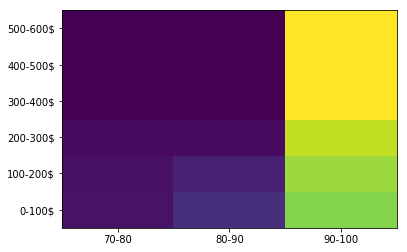

In [40]:
# define index and columns
index   = ['0-100$', '100-200$', '200-300$', '300-400$', '400-500$', '500-600$']
columns = [ '70-80', '80-90', '90-100']
        
# creating a new dataframe    
df = pd.DataFrame(heatmap, index=index, columns=columns)
        
plt.figure();
    
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

# saving the result as png file
plt.savefig('what_to_spend.png')